In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
y_test = np.load('artifacts/Y_test.npz')['arr_0']

In [3]:
# X_train = pd.read_csv('artifacts/bookings_X_train.csv')
# y_train=pd.read_csv("artifacts/bookings_y_train.csv")
# X_test=pd.read_csv("artifacts/bookings_X_test.csv")
# y_test=pd.read_csv("artifacts/bookings_y_test.csv")

In [4]:
# import pandas as pd

# train_df = pd.read_parquet('artifacts/train_with_numdocs_prior.parquet')
# test_df  = pd.read_parquet('artifacts/test_with_numdocs_prior.parquet')

# # Fit your model as usual
# # model.fit(X_train, y_train)
# # preds = model.predict(X_test)

In [5]:
# # Build X, y as you currently do, but now X includes the prior features:
# # p_numdocs_0..k, p_numdocs_ge_6, numdocs_expected, numdocs_mode
# feature_cols = [c for c in train_df.columns if c not in ['duration_log_wins','duration_log', 'duration_minutes']]  # adjust target name
# X_train = train_df[feature_cols]
# y_train = train_df['duration_log']  # replace with your actual target
# X_test  = test_df[feature_cols]
# y_test  = test_df['duration_log']

In [6]:
# # Inspect object columns
# obj_cols = X_train.select_dtypes(include='object').columns.tolist()
# print("Object columns:", obj_cols)

# # 2) Drop raw date/time strings (you already encoded time via prior features)
# drop_cols = [c for c in ['appointment_datetime','appointment_date', 'appointment_time', 'task_id'] if c in X_train.columns]
# if drop_cols:
#     X_train = X_train.drop(columns=drop_cols)
#     X_test  = X_test.drop(columns=drop_cols)

# # 3) If there are any remaining object columns, drop them (or encode similarly)
# remaining_obj = X_train.select_dtypes(include='object').columns.tolist()
# if remaining_obj:
#     print("Dropping remaining object columns:", remaining_obj)
#     X_train = X_train.drop(columns=remaining_obj)
#     X_test  = X_test.drop(columns=remaining_obj)

# # Optional: ensure consistent column order between train/test
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [7]:
# # Inspect object columns
# obj_cols = X_train.select_dtypes(include='object').columns.tolist()
# print("Object columns:", obj_cols)

# # 2) Drop raw date/time strings (you already encoded time via prior features)
# drop_cols = [c for c in ['appointment_datetime','appointment_date', 'appointment_time', 'task_id'] if c in X_train.columns]
# if drop_cols:
#     X_train = X_train.drop(columns=drop_cols)
#     X_test  = X_test.drop(columns=drop_cols)

# # 3) If there are any remaining object columns, drop them (or encode similarly)
# remaining_obj = X_train.select_dtypes(include='object').columns.tolist()
# if remaining_obj:
#     print("Dropping remaining object columns:", remaining_obj)
#     X_train = X_train.drop(columns=remaining_obj)
#     X_test  = X_test.drop(columns=remaining_obj)

# # Optional: ensure consistent column order between train/test
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [8]:
# # Inspect object columns
# obj_cols = X_train.select_dtypes(include='object').columns.tolist()
# print("Object columns:", obj_cols)

# # 2) Drop raw date/time strings (you already encoded time via prior features)
# drop_cols = [c for c in ['appointment_datetime','appointment_date', 'appointment_time', 'task_id'] if c in X_train.columns]
# if drop_cols:
#     X_train = X_train.drop(columns=drop_cols)
#     X_test  = X_test.drop(columns=drop_cols)

# # 3) If there are any remaining object columns, drop them (or encode similarly)
# remaining_obj = X_train.select_dtypes(include='object').columns.tolist()
# if remaining_obj:
#     print("Dropping remaining object columns:", remaining_obj)
#     X_train = X_train.drop(columns=remaining_obj)
#     X_test  = X_test.drop(columns=remaining_obj)

# # Optional: ensure consistent column order between train/test
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [9]:
# Define function to train and evaluate a model
def train_evaluate(model, model_name):
    # Train
    model.fit(X_train, y_train)
    
    # Predict (logged scale)
    preds_log = model.predict(X_test)
    
    # Inverse transform to original scale for metrics
    preds = np.expm1(preds_log)
    y_test_orig = np.expm1(y_test)
    
    # Metrics
    mae = mean_absolute_error(y_test_orig, preds)
    rmse = np.sqrt(mean_squared_error(y_test_orig, preds))
    r2 = r2_score(y_test_orig, preds)
    
    # Feature importance (for tree-based)
    fi = None
    if hasattr(model, 'feature_importances_'):
        fi = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        fi = model.get_feature_importance()

    if fi is not None:
        feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"f{i}" for i in range(X_train.shape[1])]
        importances = pd.Series(fi, index=feature_names).sort_values(ascending=False)
        print(f"\nTop 5 Features for {model_name}:\n{importances.head()}")
    
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [10]:
# Train base models
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(random_state=42, verbose=0)
}

In [11]:
results = []
for name, model in models.items():
    results.append(train_evaluate(model, name))


Top 5 Features for XGBoost:
f32    0.140689
f42    0.105268
f29    0.087253
f30    0.082586
f43    0.078640
dtype: float32


/Users/nithilathawalampitiya/Documents/Projects/Datathon_Rootcode/datavenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Top 5 Features for LightGBM:
f0     351
f20    253
f21    177
f1     169
f43     93
dtype: int32

Top 5 Features for CatBoost:
f38    13.488622
f40    10.776282
f32    10.680422
f42    10.208176
f29     7.298508
dtype: float64


In [12]:
# Step 4: Compare in a table
results_df = pd.DataFrame(results)
print("\nBase Model Comparison:")
print(results_df)


Base Model Comparison:
      Model       MAE       RMSE        R2
0   XGBoost  8.131592  11.292538  0.675969
1  LightGBM  8.055760  11.127945  0.685346
2  CatBoost  8.053831  11.185297  0.682094


/Users/nithilathawalampitiya/Documents/Projects/Datathon_Rootcode/datavenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


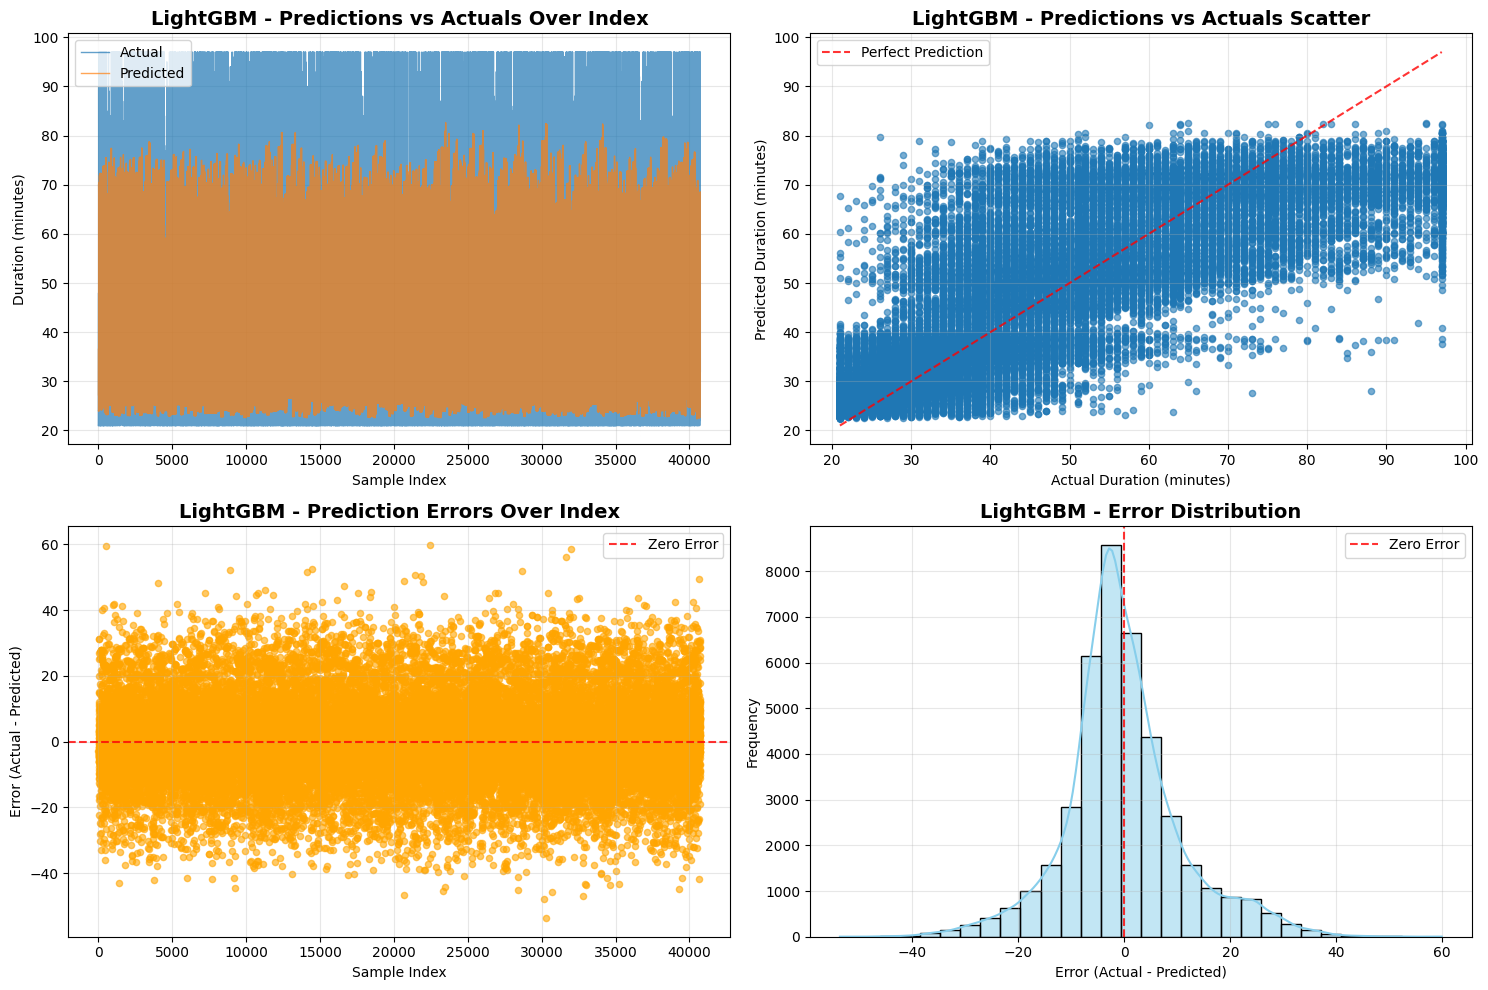


LightGBM Model Performance Summary:
MAE: 8.06 minutes
RMSE: 11.13 minutes
R²: 0.685


In [13]:
# ... existing code ...

# Add this new cell after the model comparison results
import seaborn as sns
from datetime import datetime

# Get the best model (highest R2 score)
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

# Retrain the best model to get predictions
best_model.fit(X_train, y_train)
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log)
y_test_orig = np.expm1(y_test)

# Create a dataframe for visualization with dates
viz_df = pd.DataFrame({
    'index': range(len(y_test)),  # Changed from test_df to X_test
    'actual': y_test_orig,
    'predicted': preds,
    'error': y_test_orig - preds
})

# Create the visualization
plt.figure(figsize=(15, 10))

# Plot 1: Predictions vs Actuals over index
plt.subplot(2, 2, 1)
plt.plot(viz_df['index'], viz_df['actual'], label='Actual', alpha=0.7, linewidth=1)
plt.plot(viz_df['index'], viz_df['predicted'], label='Predicted', alpha=0.7, linewidth=1)
plt.title(f'{best_model_name} - Predictions vs Actuals Over Index', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot of predictions vs actuals
plt.subplot(2, 2, 2)
plt.scatter(viz_df['actual'], viz_df['predicted'], alpha=0.6, s=20)
plt.plot([viz_df['actual'].min(), viz_df['actual'].max()], 
         [viz_df['actual'].min(), viz_df['actual'].max()], 'r--', alpha=0.8, label='Perfect Prediction')
plt.title(f'{best_model_name} - Predictions vs Actuals Scatter', fontsize=14, fontweight='bold')
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Error over index
plt.subplot(2, 2, 3)
plt.scatter(viz_df['index'], viz_df['error'], alpha=0.6, s=20, color='orange')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.8, label='Zero Error')
plt.title(f'{best_model_name} - Prediction Errors Over Index', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Error (Actual - Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Error distribution
plt.subplot(2, 2, 4)
sns.histplot(viz_df['error'], bins=30, kde=True, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero Error')
plt.title(f'{best_model_name} - Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{best_model_name} Model Performance Summary:")
print(f"MAE: {results_df.loc[results_df['R2'].idxmax(), 'MAE']:.2f} minutes")
print(f"RMSE: {results_df.loc[results_df['R2'].idxmax(), 'RMSE']:.2f} minutes")
print(f"R²: {results_df.loc[results_df['R2'].idxmax(), 'R2']:.3f}")



/Users/nithilathawalampitiya/Documents/Projects/Datathon_Rootcode/datavenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Visualizing: First 1000 samples
Number of samples in range: 1000
Sample range: 0 to 999


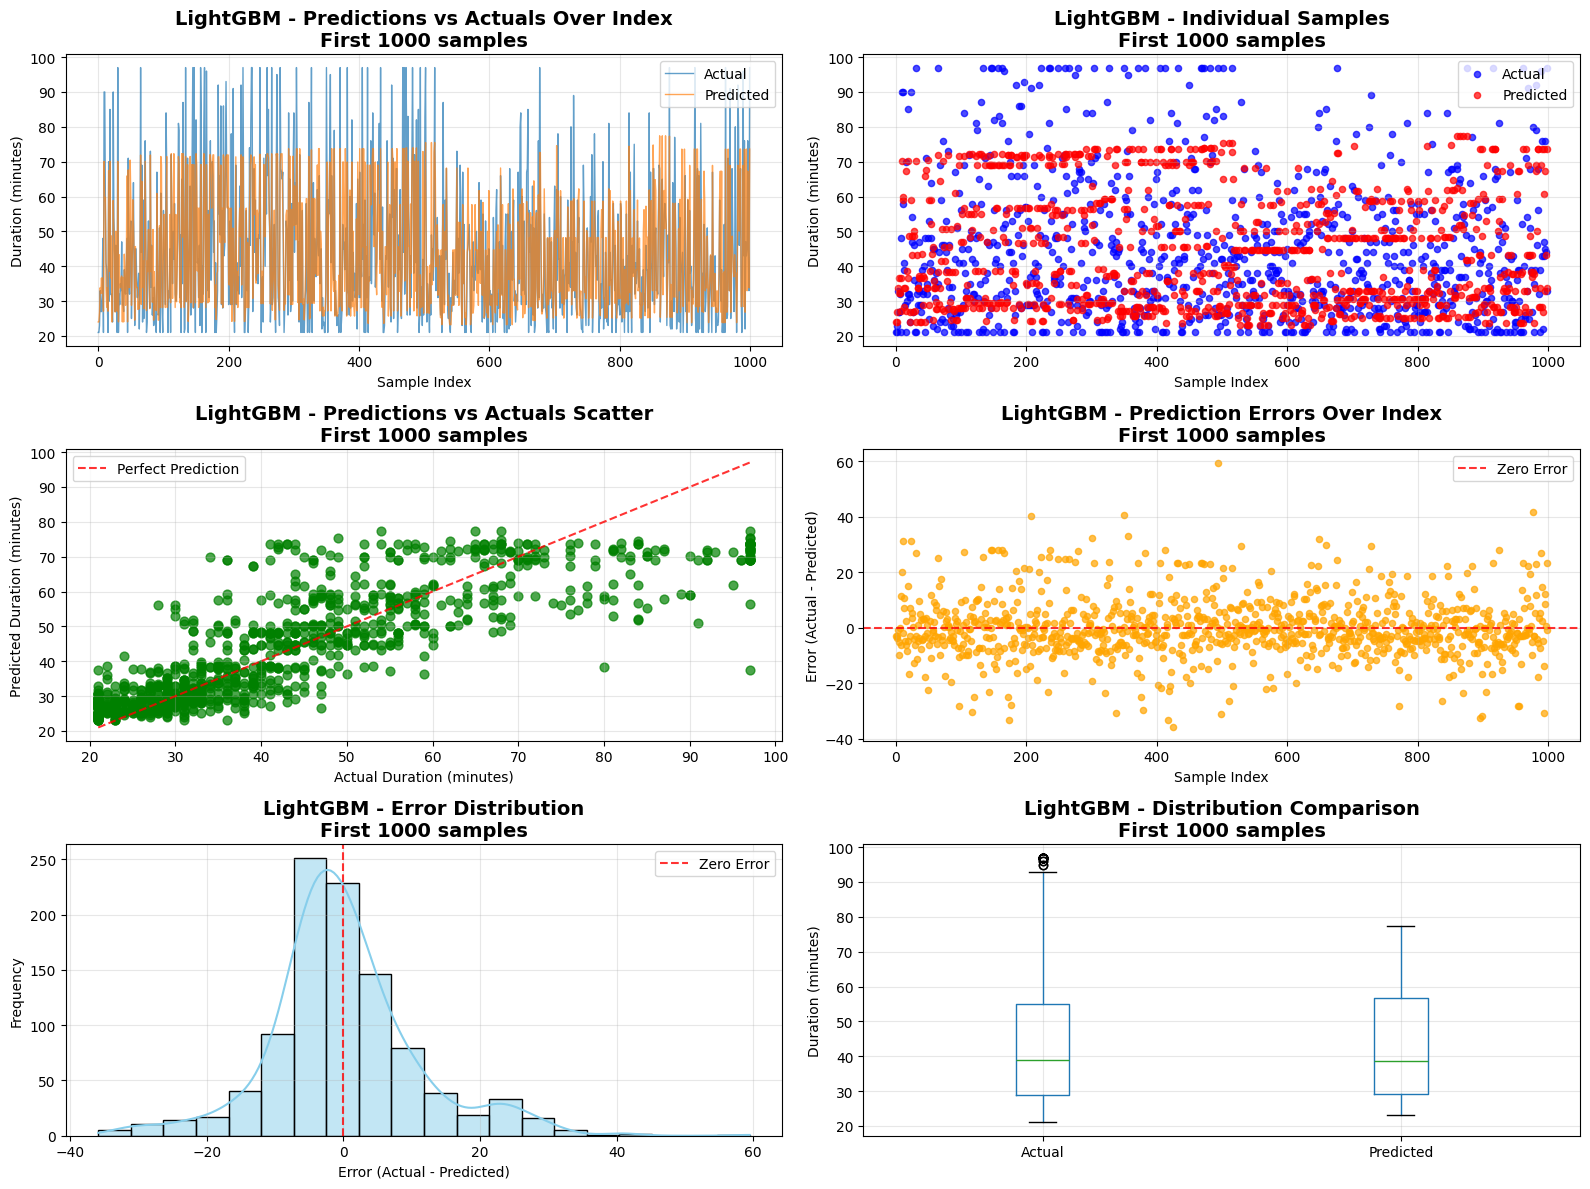


LightGBM Model Performance for First 1000 samples:
Number of samples: 1000
MAE: 7.80 minutes
RMSE: 10.93 minutes
Mean Error: 0.02 minutes
Error Std: 10.93 minutes
Min Error: -35.90 minutes
Max Error: 59.47 minutes

Top 5 Worst Predictions in First 1000 samples (Highest Absolute Error):
     index  actual  predicted  error
494    494    97.0      37.53  59.47
977    977    80.0      38.46  41.54
350    350    97.0      56.32  40.68
207    207    91.0      50.88  40.12
425    425    34.0      69.90 -35.90

Top 5 Best Predictions in First 1000 samples (Lowest Absolute Error):
     index  actual  predicted  error
968    968    33.0      32.96   0.04
728    728    33.0      32.92   0.08
817    817    33.0      32.92   0.08
902    902    29.0      29.11  -0.11
560    560    35.0      35.11  -0.11


In [14]:
# Get the best model (highest R2 score)
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

# Retrain the best model to get predictions
best_model.fit(X_train, y_train)
preds_log = best_model.predict(X_test)
preds = np.expm1(preds_log)
y_test_orig = np.expm1(y_test)

# Create a dataframe for visualization with index (since no dates available)
viz_df = pd.DataFrame({
    'index': range(len(y_test)),
    'actual': y_test_orig,
    'predicted': preds,
    'error': y_test_orig - preds
})

# Sort by index for proper visualization
viz_df = viz_df.sort_values('index')

# Choose a specific range to visualize (you can change this)
# Option 1: Choose a range with most data (e.g., first 1000 samples)
sample_range = 1000
if len(viz_df) > sample_range:
    best_range = f"First {sample_range} samples"
    range_data = viz_df.head(sample_range).copy()
else:
    best_range = f"All {len(viz_df)} samples"
    range_data = viz_df.copy()

print(f"Visualizing: {best_range}")
print(f"Number of samples in range: {len(range_data)}")
print(f"Sample range: {range_data['index'].min()} to {range_data['index'].max()}")

# Create the visualization for the selected range
plt.figure(figsize=(16, 12))

# Plot 1: Predictions vs actuals over index (line plot)
plt.subplot(3, 2, 1)
plt.plot(range_data['index'], range_data['actual'], label='Actual', alpha=0.7, linewidth=1)
plt.plot(range_data['index'], range_data['predicted'], label='Predicted', alpha=0.7, linewidth=1)
plt.title(f'{best_model_name} - Predictions vs Actuals Over Index\n{best_range}', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Individual samples over index
plt.subplot(3, 2, 2)
plt.scatter(range_data['index'], range_data['actual'], 
           alpha=0.7, s=20, label='Actual', color='blue')
plt.scatter(range_data['index'], range_data['predicted'], 
           alpha=0.7, s=20, label='Predicted', color='red')
plt.title(f'{best_model_name} - Individual Samples\n{best_range}', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Duration (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Scatter plot for the range
plt.subplot(3, 2, 3)
plt.scatter(range_data['actual'], range_data['predicted'], alpha=0.7, s=40, color='green')
plt.plot([range_data['actual'].min(), range_data['actual'].max()], 
         [range_data['actual'].min(), range_data['actual'].max()], 'r--', alpha=0.8, label='Perfect Prediction')
plt.title(f'{best_model_name} - Predictions vs Actuals Scatter\n{best_range}', fontsize=14, fontweight='bold')
plt.xlabel('Actual Duration (minutes)')
plt.ylabel('Predicted Duration (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Error over index for the range
plt.subplot(3, 2, 4)
plt.scatter(range_data['index'], range_data['error'], 
           alpha=0.7, s=20, color='orange')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.8, label='Zero Error')
plt.title(f'{best_model_name} - Prediction Errors Over Index\n{best_range}', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Error (Actual - Predicted)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Error distribution for the range
plt.subplot(3, 2, 5)
sns.histplot(range_data['error'], bins=20, kde=True, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero Error')
plt.title(f'{best_model_name} - Error Distribution\n{best_range}', fontsize=14, fontweight='bold')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Box plot comparison
plt.subplot(3, 2, 6)
comparison_data = pd.DataFrame({
    'Actual': range_data['actual'],
    'Predicted': range_data['predicted']
})
comparison_data.boxplot(column=['Actual', 'Predicted'], ax=plt.gca())
plt.title(f'{best_model_name} - Distribution Comparison\n{best_range}', fontsize=14, fontweight='bold')
plt.ylabel('Duration (minutes)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics for the range
print(f"\n{best_model_name} Model Performance for {best_range}:")
print(f"Number of samples: {len(range_data)}")
print(f"MAE: {abs(range_data['error']).mean():.2f} minutes")
print(f"RMSE: {np.sqrt((range_data['error']**2).mean()):.2f} minutes")
print(f"Mean Error: {range_data['error'].mean():.2f} minutes")
print(f"Error Std: {range_data['error'].std():.2f} minutes")
print(f"Min Error: {range_data['error'].min():.2f} minutes")
print(f"Max Error: {range_data['error'].max():.2f} minutes")

# Show top 5 worst predictions for the range (highest absolute error)
worst_predictions = range_data.loc[range_data['error'].abs().nlargest(5).index][['index', 'actual', 'predicted', 'error']]
print(f"\nTop 5 Worst Predictions in {best_range} (Highest Absolute Error):")
print(worst_predictions.round(2))

# Show top 5 best predictions for the range (lowest absolute error)
best_predictions = range_data.loc[range_data['error'].abs().nsmallest(5).index][['index', 'actual', 'predicted', 'error']]
print(f"\nTop 5 Best Predictions in {best_range} (Lowest Absolute Error):")
print(best_predictions.round(2))